In [135]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

* Python libraries.
* Models for the NACA airfoil and the panel discretization. 

In [136]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from naca import NacaGenerator
from panel import Panel

# Vortex Panel Method

Define the NACA profile and the number of points. 

In [139]:
NACA = '0012'
NUM_POINTS_X = 100

Helper method to create the airfoil.

In [140]:
def generate_airfoil(NACA, NUM_POINTS_X):
    airfoil = NacaGenerator(naca=NACA)

    airfoil.generate_cosine_distribution(N=NUM_POINTS_X);
    airfoil.generate_naca();
    
    return airfoil

Generate the airfoil. 

Generating cosine distribution with 100 points ...


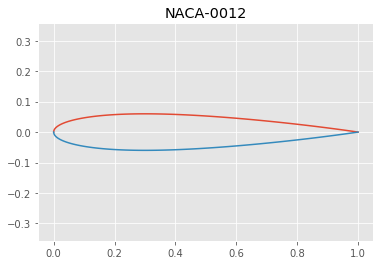

In [141]:
airfoil = generate_airfoil(NACA, NUM_POINTS_X=NUM_POINTS_X)

airfoil.plot()

Get the $(x,y)$ coordinates of the airfoil in the **clockwise** direction, starting by the trailing-edge. 

In [142]:
x, y = airfoil.clockwise_naca()

In [143]:
airfoil.parse_naca()

(0.12, 1e-12, 1e-12)

In [144]:
print(len(y[0:NUM_POINTS_X]))
print(len(y[NUM_POINTS_X+1:]))

100
98


Build a list of panels in the **clockwise** direction. 

In [145]:
print('Generating panels ...')

panels = []

for x_start, x_end, y_start, y_end in zip(x, x[1:], y, y[1:]):
    
    start = np.array([x_start, y_start])
    end   = np.array([x_end,   y_end])
    
    panel = Panel(start=start, end=end)
    
    panels.append(panel)

NUM_PANELS = len(panels)
print('Number of panels:', NUM_PANELS)

Generating panels ...
Number of panels: 198


Get the control points and the angles. 

In [146]:
mid_points = []
thetas     = []

for panel in panels:
    
    mid_points.append({'x_c': panel.mid_point})
    thetas.append(panel.angle)

Here is where the bug is. We are counting *twice* each boundary point, since we include it in the `#Start` *and* in the `#End`.

In [147]:
boundary_points = []
control_points  = []

for panel in panels:
    
    # Start
    boundary_points.append({'x':panel.start[0], 'y': panel.start[1], 
                            'S':panel.length,   'theta':panel.angle, 
                            'x_c': panel.mid_point_x, 'y_c': panel.mid_point_y})
    # End
    # boundary_points.append({'x':panel.end[0], 'y': panel.end[1], 
    #                        'S':panel.length, 'theta':panel.angle, 
    #                         'x_c': panel.mid_point_x, 'y_c': panel.mid_point_y})
    
    # Middle point
    control_points.append({'S':panel.length,   'theta':panel.angle, 
                           'x': panel.mid_point_x, 'y': panel.mid_point_y})
    
# Last point
panel = panels[-1]
boundary_points.append({'x':panel.start[0], 'y': panel.start[1], 
                        'S':panel.length,   'theta':panel.angle, 
                        'x_c': panel.mid_point_x, 'y_c': panel.mid_point_y})

In [148]:
boundary_points

[{'x': 1.0,
  'y': 1.6653345369377347e-17,
  'S': 0.00025437313955421954,
  'theta': 0.14431591825082057,
  'x_c': 0.9998741355957963,
  'y_c': -1.829139923844679e-05},
 {'x': 0.9997482711915925,
  'y': -3.658279847691024e-05,
  'S': 0.0007628529763928763,
  'theta': 0.1442228897040827,
  'x_c': 0.9993708047137672,
  'y_c': -9.140272200849566e-05},
 {'x': 0.9989933382359418,
  'y': -0.0001462226455400811,
  'S': 0.0012705338840143725,
  'theta': 0.14403721629217392,
  'x_c': 0.9983646497612417,
  'y_c': -0.00023740866084079662},
 {'x': 0.9977359612865416,
  'y': -0.0003285946761415121,
  'S': 0.0017768845650110968,
  'theta': 0.14375966086848407,
  'x_c': 0.9968566838509691,
  'y_c': -0.0004558773561755875},
 {'x': 0.9959774064153966,
  'y': -0.0005831600362096629,
  'S': 0.0022813756938294474,
  'theta': 0.14339135647638962,
  'x_c': 0.994848425376796,
  'y_c': -0.0007461648784054321},
 {'x': 0.9937194443381954,
  'y': -0.0009091697206012011,
  'S': 0.002783480683307257,
  'theta': 0.

In [149]:
N_c = len(control_points)
N_b = len(boundary_points)

print(f'We have {N_c} control points.')
print(f'We have {N_b} boundary points.')

We have 198 control points.
We have 199 boundary points.


In [165]:
A = np.zeros(shape = (N_c, N_b))
B = np.zeros(shape = (N_c, N_b))
C = np.zeros(shape = (N_c, N_b))
D = np.zeros(shape = (N_c, N_b))
E = np.zeros(shape = (N_c, N_b))
F = np.zeros(shape = (N_c, N_b))
G = np.zeros(shape = (N_c, N_b))
P = np.zeros(shape = (N_c, N_b))
Q = np.zeros(shape = (N_c, N_b))

C1 = np.zeros(shape = (N_c, N_b))
C2 = np.zeros(shape = (N_c, N_b))

Ct1 = np.zeros(shape = (N_c, N_b))
Ct2 = np.zeros(shape = (N_c, N_b))

for row, control in enumerate(control_points, start = 0):
    
    for col, boundary in enumerate(boundary_points, start = 0):
        
        # Normal matrices
        dx = (control['x'] - boundary['x'])
        dy = (control['y'] - boundary['y'])
        
        A[row][col] -= dx * np.cos(boundary['theta'])
        A[row][col] -= dy * np.sin(boundary['theta'])
        
        B[row][col] += dx**2.0 + dy**2.0
        
        C[row][col] += np.sin(control['theta'] - boundary['theta'])
        
        D[row][col] += np.cos(control['theta'] - boundary['theta'])
        
        E[row][col] += dx * np.sin(boundary['theta'])
        E[row][col] -= dy * np.cos(boundary['theta'])
        
        S = boundary['S']
        
        num = S ** 2.0 - 2.0 * A[row][col] * S
        den = B[row][col]
        
        F[row][col] += np.log(1.0 + num / den)
        
        num = E[row][col] * S
        den = B[row][col] + A[row][col] * S
        
        G[row][col] += np.arctan2(num, den)
        
        P[row][col] += dx * np.sin(control['theta'] - 2.0 * boundary['theta'])
        P[row][col] += dy * np.cos(control['theta'] - 2.0 * boundary['theta'])
        
        Q[row][col] += dx * np.cos(control['theta'] - 2.0 * boundary['theta'])
        Q[row][col] -= dy * np.sin(control['theta'] - 2.0 * boundary['theta'])
    
        # Normal matrices
        C2[row][col] += D[row][col] 
        C2[row][col] += Q[row][col] * F[row][col] / 2.0 / S 
        C2[row][col] -= A[row][col] * C[row][col] * G[row][col] / S
        C2[row][col] -= D[row][col] * E[row][col] * G[row][col] / S
        
        C1[row][col] += D[row][col] * F[row][col] / 2.0
        C1[row][col] += C[row][col] * G[row][col]
        C1[row][col] -= C2[row][col]
        
        # Tangential matrices
        Ct2[row][col] += C[row][col]
        Ct2[row][col] += P[row][col] * F[row][col] / 2.0 / S
        Ct2[row][col] += A[row][col] * D[row][col] * G[row][col] / S
        Ct2[row][col] -= C[row][col] * E[row][col] * G[row][col] / S
        
        Ct1[row][col] += C[row][col] * F[row][col] / 2.0
        Ct1[row][col] -= D[row][col] * G[row][col]
        Ct1[row][col] -= Ct2[row][col]
        
        
# Apply special conditions to the diagonals
np.fill_diagonal(C1, -1)
np.fill_diagonal(C2,  1)

np.fill_diagonal(Ct1, np.pi / 2.0)
np.fill_diagonal(Ct2, np.pi / 2.0)

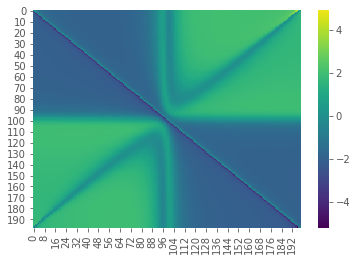

In [166]:
sns.heatmap(C1, cmap = 'viridis', center = 0.0)

In [167]:
def summand(i, j, gamma):
    
    return C1[i][j] * gamma[j] + C2[i][j] * gamma[j+1]

In [168]:
def system_of_equations(gamma):
        
    # Prepare gammas
    result = np.zeros_like(gamma)
    
    # Matrix-product implementation
    for i in range(len(result)-1):
        for j in range(len(gamma)-1):
            
            result[i] += summand(i, j, gamma)
            
    # Compatibility condition at the end
    result[-1] = gamma[0] + gamma[-1]
    
    return result

## Airflow solution

So far, everything depends on the geometry. So now we are going to compute the RHS, which depends on the incidence angle. 

In [169]:
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import gmres

An iterative linear operator will be used. This will not affect our solution, but will simplify the way we build the matrix. 

In [170]:
A = LinearOperator((N_c, N_c), matvec=system_of_equations)
A

<198x198 _CustomLinearOperator with dtype=float64>

In [171]:
ALPHA = 0.0
ALPHA = np.deg2rad(ALPHA)

# RHS
b = np.zeros(N_c)

for idx in range(len(b)):
    b[idx] = np.sin(thetas[idx] - ALPHA)

# Kutta condition
b[-1] = 0.0

In [172]:
ITERATIONS_MAX     = 10000
ITERATIONS_RESTART = ITERATIONS_MAX

In [173]:
gammas, info = gmres(A, b, 
                     x0      = np.ones(N_c), 
                     restart = ITERATIONS_RESTART, 
                     maxiter = ITERATIONS_MAX, 
                     tol     = 1e-8,
                     atol    = 1e-8) 

In [174]:
info

0

In [175]:
def summand_tangential(i, j, gamma):
    
    return Ct1[i][j] * gamma[j] + Ct2[i][j] * gamma[j+1]

In [176]:
def compute_velocity(gamma):
    
    # Prepare gammas
    result = np.zeros_like(gamma)
    
    # Matrix-product implementation
    for i in range(len(result)):
        for j in range(len(gamma)-1):
            
            result[i] += summand_tangential(i, j, gamma)
    
    # Angles
    theta = np.array(thetas)
    
    
    return np.cos(theta - ALPHA) + result

In [177]:
def compute_pressure_distribution(gamma):
    
    velocity = compute_velocity(gamma)
    
    return 1.0 - np.power(velocity, 2.0)

In [178]:
cp = compute_pressure_distribution(gammas)

Text(0.5, 0, '$x$')

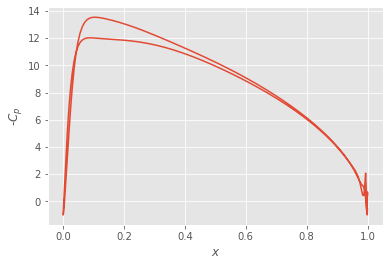

In [179]:
plt.plot(x[:-1], -cp)
plt.ylabel('-$C_p$')
plt.xlabel('$x$')

Text(0.5, 0, '$x$')

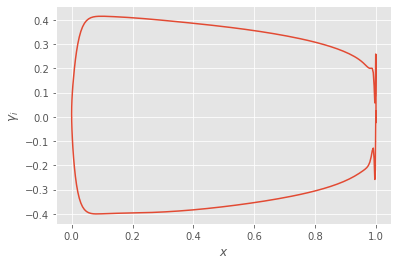

In [180]:
plt.plot(x[:-1], gammas)
plt.ylabel('$\gamma_i$')
plt.xlabel('$x$')

In [181]:
gammas

array([-0.02282161,  0.25369594,  0.25872696,  0.08660712,  0.05750185,
        0.12768522,  0.18201004,  0.19961183,  0.20042114,  0.19980279,
        0.2024687 ,  0.20800827,  0.21495982,  0.22225131,  0.22935472,
        0.23609332,  0.24245623,  0.2484898 ,  0.25424835,  0.25977728,
        0.26511014,  0.27027055,  0.2752751 ,  0.28013566,  0.28486115,
        0.28945862,  0.29393394,  0.29829221,  0.30253802,  0.30667554,
        0.31070861,  0.31464078,  0.31847527,  0.32221502,  0.32586266,
        0.32942047,  0.33289042,  0.33627414,  0.33957295,  0.34278794,
        0.34591994,  0.34896966,  0.35193775,  0.3548249 ,  0.35763194,
        0.36035991,  0.36301021,  0.36558458,  0.36808521,  0.37051473,
        0.37287617,  0.3751729 ,  0.37740854,  0.3795868 ,  0.38171133,
        0.38378551,  0.38581226,  0.38779385,  0.38973167,  0.39162608,
        0.39347627,  0.39528014,  0.3970343 ,  0.39873407,  0.40037364,
        0.40194627,  0.40344466,  0.40486149,  0.40618999,  0.40